# Comparing fast XGM data from two simultaneous recordings

Here we will look at XGM data that was recorded by the X-ray photon diagnostics group at the same short time interval, but at different locations of the EuXFEL-SASE. We will compare an XGM in SASE1 (XTD2) to another one in SASE3 (XTD10). These data were stored in two different runs, belonging to two different proposals even.  
Conceptually, this section makes use of the data-object format *xarray.DataArray*.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from karabo_data import RunDirectory

## SASE1

Load the SASE1 run:

In [2]:
sa1_data = RunDirectory('/gpfs/exfel/exp/XMPL/201750/p700000/raw/r0008')
sa1_data.info()

# of trains:    6296
Duration:       0:10:29.500000
First train ID: 38227866
Last train ID:  38234161

0 detector modules ()

1 instrument sources (excluding detectors):
  - SA1_XTD2_XGM/XGM/DOOCS:output

0 control sources:



We are interested in fast, i.e. pulse-resolved data from the instrument source `SA1_XTD2_XGM/DOOCS:output`.

In [3]:
sa1_data.keys_for_source('SA1_XTD2_XGM/XGM/DOOCS:output')

{'data.intensityTD'}

We are particularly interested in data for quantity "intensityTD". The ***xarray DataArray*** class is suited for work with axis-labeled data, and the karabo_data method `get_array()` serves the purpose of shaping a 2D array of that type from pulse-resolved data (which is originally stored "flat" in terms of pulses: there is one dimension of N(train) x N(pulse) values in HDF5, and the same number of train and pulse identifiers for reference).  
The unique train identifier values are taken as coordinate values ("labels").

In [4]:
sa1_flux = sa1_data.get_array('SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensityTD')
print(sa1_flux)

<xarray.DataArray (trainId: 6295, dim_0: 1000)>
array([[2.045129e+03, 7.820441e+01, 1.964445e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       [2.091464e+03, 4.242367e+01, 1.915582e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       [1.872965e+03, 4.368253e+01, 1.984025e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       ...,
       [1.611342e+03, 5.569377e+01, 1.811418e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       [1.536590e+03, 6.418680e+01, 1.643087e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00],
       [1.871557e+03, 5.983860e+01, 1.738864e+03, ..., 1.000000e+00,
        1.000000e+00, 1.000000e+00]], dtype=float32)
Coordinates:
  * trainId  (trainId) uint64 38227866 38227867 38227868 ... 38234160 38234161
Dimensions without coordinates: dim_0


Next, we will plot a portion of the data in two dimensions, taking the first 1500 trains for the x-Axis and the first 30 pulses per train for the y-Axis (1500, 30). Because the Matplotlib convention takes the slow axis to be *y*, we have to transpose to (30, 1500):

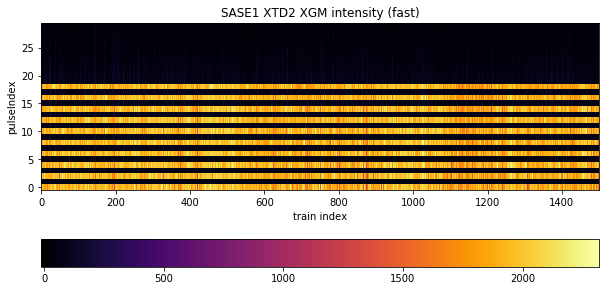

In [5]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
image = ax.imshow(sa1_flux[:1500, :30].transpose(), origin='lower', cmap='inferno')
ax.set_title('SASE1 XTD2 XGM intensity (fast)')
fig.colorbar(image, orientation='horizontal')
ax.set_xlabel('train index')
ax.set_ylabel('pulseIndex')
ax.set_aspect(15)

The pattern tells us what was done in this experiment: the lasing scheme was set to provide an alternating X-ray pulse delivery within a train, where every "even" electron bunch caused lasing in SASE1 and every "odd" bunch caused lasing in SASE3. This scheme was applied for the first 20 pulses.
Therefore, we see signal only for data at even pulses here (0,2,...18), throughout all trains, of which 1500 are depicted. The intensity varies somewhat around 2000 units, but for odd pulses it is suppressed and neglegibly small.

A relevant measure to judge the efficiency of pulse suppression is the ratio of mean intensity between the odd and even set. The numpy `mean` method can work with DataArray objects and average over a specified dimension.  
We make use of the numpy indexing and slicing syntax with square brackets and comma to seperate axes (dimensions). We specify `[:, :20:2]` to take every element of the slow axis (trains) and every second pulse up to but excluding # 20. That is, start:end:step = 0:20:2 (start index 0 is default, thus not put, and stop means first index beyond range). We specify `axis=1` to explicitly average over that dimension. The result is a DataArray reduced to the "trainId" dimension.

In [6]:
sa1_mean_on = np.mean(sa1_flux[:, :20:2], axis=1)
sa1_stddev_on = np.std(sa1_flux[:, :20:2], axis=1)
print(sa1_mean_on)

<xarray.DataArray (trainId: 6295)>
array([1931.4768, 1977.8414, 1873.7828, ..., 1771.5828, 1697.2053, 1857.7439],
      dtype=float32)
Coordinates:
  * trainId  (trainId) uint64 38227866 38227867 38227868 ... 38234160 38234161


Accordingly for the odd "off" pulses:

In [7]:
sa1_mean_off = np.mean(sa1_flux[:, 1:21:2], axis=1)
sa1_stddev_off = np.std(sa1_flux[:, 1:21:2], axis=1)
print(sa1_mean_off)

<xarray.DataArray (trainId: 6295)>
array([96.10835 , 84.489044, 59.212048, ..., 90.2944  , 84.33766 , 85.03202 ],
      dtype=float32)
Coordinates:
  * trainId  (trainId) uint64 38227866 38227867 38227868 ... 38234160 38234161


Now we can calculate the ratio of averages for every train - data types like *numpy ndarray* or *xarray DataArray* may be just divided "as such", a shortcut notation for dividing every corresponding element - and plot.  

Text(0, 0.5, 'suppression')

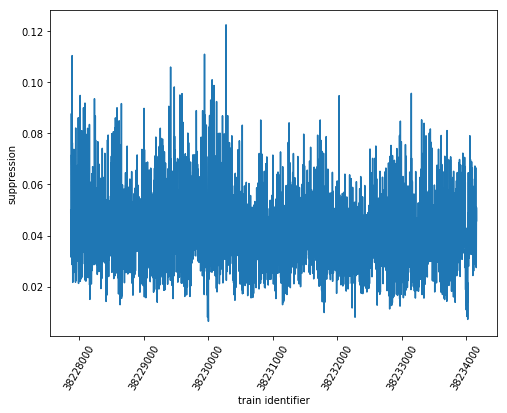

In [8]:
sa1_suppression = sa1_mean_off / sa1_mean_on
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(sa1_suppression.coords['trainId'].values, sa1_suppression)
ax.set_xlabel('train identifier')
ax.ticklabel_format(style='plain', useOffset=False)
plt.xticks(rotation=60)
ax.set_ylabel('suppression')

Moreover, the relative error of this ratio can be calculated by multiplicative error propagation as the square root of the sum of squared relative errors (enumerator and denominator), and from it the absolute error. The Numpy functions "sqrt" and "square" applied to array-like structures perform these operations element-wise, so the entire calculation can be conveniently done using the arrays as arguments, and we obtain individual errors for every train in the end.

In [9]:
sa1_rel_error = np.sqrt(np.square(sa1_stddev_off / sa1_mean_off) + np.square(sa1_stddev_on / sa1_mean_on))
sa1_abs_error = sa1_rel_error * sa1_suppression

We can as well plot the suppression ratio values with individual error bars according to the respective absolute error. Here, we restrict ourselves to the first 50 trains for clarity:

Text(0, 0.5, 'suppression')

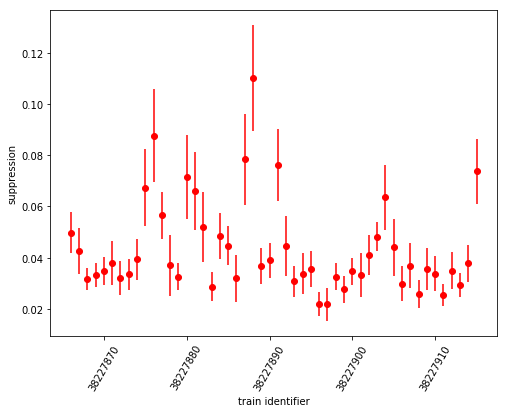

In [10]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(sa1_suppression.coords['trainId'].values[:50], sa1_suppression[:50], yerr=sa1_abs_error[:50], fmt='ro')
ax.set_xlabel('train identifier')
ax.ticklabel_format(style='plain', useOffset=False)
plt.xticks(rotation=60)
ax.set_ylabel('suppression')

Finally, we draw a histogram of suppression ratio values:

Text(0, 0.5, 'frequency')

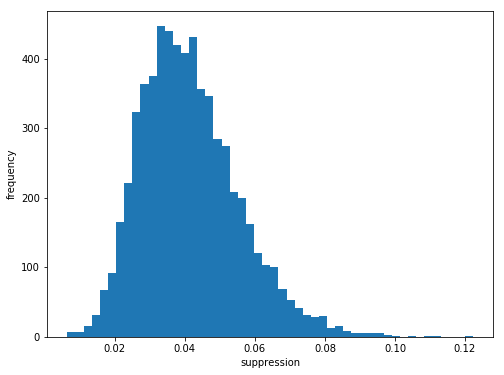

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
_ = ax.hist(sa1_suppression, bins=50)
ax.set_xlabel('suppression')
ax.set_ylabel('frequency')

We see that there is a suppression of signal from odd pulses to approximately 4% of the intensity of even pulses. 

***

## SASE3

We repeat everything for the second data set from the different run - SASE3:

In [12]:
sa3_data = RunDirectory('/gpfs/exfel/exp/XMPL/201750/p700000/raw/r0009')
sa3_data.info()

# of trains:    6236
Duration:       0:10:23.500000
First train ID: 38227850
Last train ID:  38234085

0 detector modules ()

1 instrument sources (excluding detectors):
  - SA3_XTD10_XGM/XGM/DOOCS:output

0 control sources:



In [13]:
sa3_flux = sa3_data.get_array('SA3_XTD10_XGM/XGM/DOOCS:output', 'data.intensityTD')
print(sa3_flux.shape)

(6235, 1000)


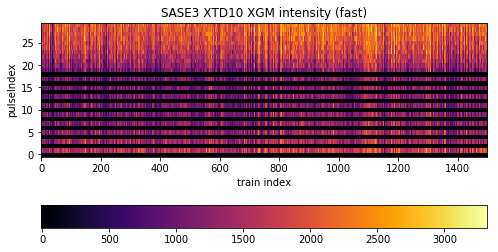

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
image = ax.imshow(sa3_flux[:1500, :30].transpose(), origin='lower', cmap='inferno')
ax.set_title('SASE3 XTD10 XGM intensity (fast)')
fig.colorbar(image, orientation='horizontal')
ax.set_xlabel('train index')
ax.set_ylabel('pulseIndex')
ax.set_aspect(15)

The difference here is that the selection scheme (indexing and slicing) shifts by one with respect to SASE1 data: odd pulses are "on", even pulses are "off". Moreover, while the alternating scheme is upheld to pulse # 19, pulses beyond that exclusively went to SASE3. There is signal up to pulse # 70, which we could see with a wider plotting range (but not done due to emphasis on the alternation).

In [15]:
sa3_mean_on = np.mean(sa3_flux[:, 1:21:2], axis=1)
sa3_stddev_on = np.std(sa3_flux[:, 1:21:2], axis=1)
print(sa3_mean_on)

<xarray.DataArray (trainId: 6235)>
array([ 963.89746, 1073.1758 ,  902.22656, ...,  883.9881 ,  960.5875 ,
        889.625  ], dtype=float32)
Coordinates:
  * trainId  (trainId) uint64 38227850 38227851 38227852 ... 38234084 38234085


In [16]:
sa3_mean_off = np.mean(sa3_flux[:, :20:2], axis=1)
sa3_stddev_off = np.std(sa3_flux[:, :20:2], axis=1)
print(sa3_mean_off)

<xarray.DataArray (trainId: 6235)>
array([5.435107, 6.615537, 8.361802, ..., 2.378666, 7.135999, 4.612433],
      dtype=float32)
Coordinates:
  * trainId  (trainId) uint64 38227850 38227851 38227852 ... 38234084 38234085


The suppression ratio calculation and its plot: 

Text(0, 0.5, 'suppression')

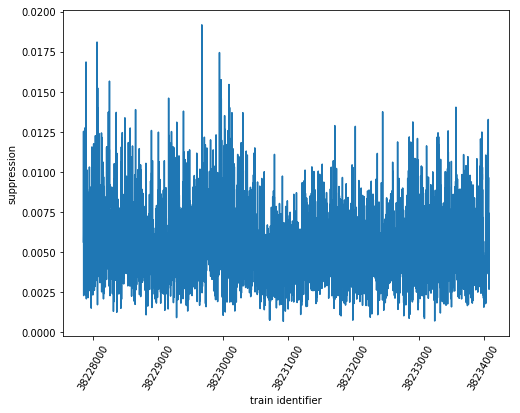

In [17]:
sa3_suppression = sa3_mean_off / sa3_mean_on
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(sa3_suppression.coords['trainId'].values, sa3_suppression)
ax.set_xlabel('train identifier')
ax.ticklabel_format(style='plain', useOffset=False)
plt.xticks(rotation=60)
ax.set_ylabel('suppression')

The error calculation with (selective) plot

Text(0, 0.5, 'suppression')

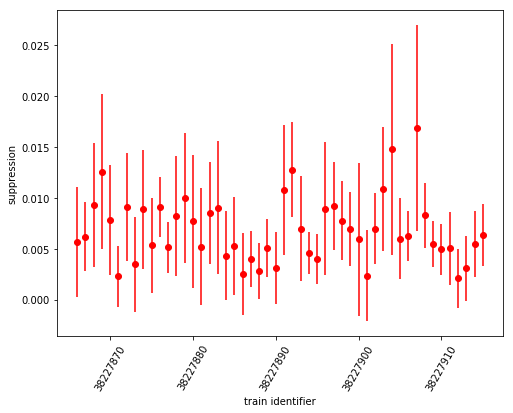

In [18]:
sa3_rel_error = np.sqrt(np.square(sa3_stddev_off / sa3_mean_off) + np.square(sa3_stddev_on / sa3_mean_on))
sa3_abs_error = sa3_rel_error * sa3_suppression
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(sa1_suppression.coords['trainId'].values[:50], sa3_suppression[:50], yerr=sa3_abs_error[:50], fmt='ro')
ax.set_xlabel('train identifier')
ax.ticklabel_format(style='plain', useOffset=False)
plt.xticks(rotation=60)
ax.set_ylabel('suppression')

The histogram:

Text(0, 0.5, 'frequency')

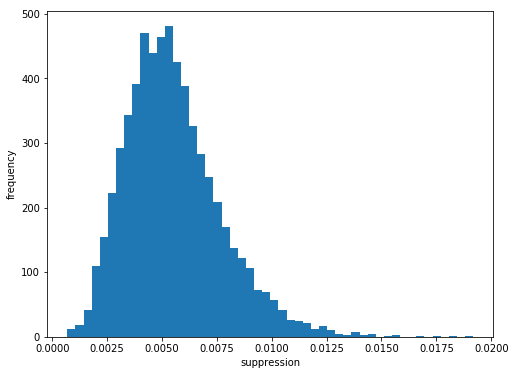

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
_ = ax.hist(sa3_suppression, bins=50)
ax.set_xlabel('suppression')
ax.set_ylabel('frequency')

Here, suppression of signal for even "off" pulses is to approximately 0.5% of intensity from odd "on" pulses. The "suppression factor" is almost 10 times the value of SASE1. However, the relative error of these values is larger as well, as can be seen in the error-bar plot. For the smaller quantities, it is ~ 100% (!). 

# Overall comparison of suppression ratio (with error)

We ultimately want a single overall compression ratio with error for both beamlines, to complement the error-bar plots. In order to keep the error calculation simple, we do not average the mean values, but create one mean and standard deviation from a flat array of original values.  
Because labeled axes are not required for this purpose, we can afford to move from the xarray.DataArray regime to Numpy array.

In [20]:
sa1_on_all = np.array(sa1_flux[:, :20:2]).flatten()
sa1_on_all.shape

(62950,)

In [21]:
sa1_mean_on_overall = np.mean(sa1_on_all)
sa1_stddev_on_overall = np.std(sa1_on_all)

In [22]:
sa1_off_all = np.array(sa1_flux[:, 1:21:2]).flatten()
sa1_off_all.shape

(62950,)

In [23]:
sa1_mean_off_overall = np.mean(sa1_off_all)
sa1_stddev_off_overall = np.std(sa1_off_all)

In [24]:
sa1_suppression_overall = sa1_mean_off_overall / sa1_mean_on_overall
sa1_rel_error_overall = np.sqrt(np.square(sa1_stddev_off_overall / sa1_mean_off_overall) + \
                        np.square(sa1_stddev_on_overall / sa1_mean_on_overall))
sa1_abs_error_overall = sa1_rel_error_overall * sa1_suppression_overall
print('SA1 suppression ratio =', sa1_suppression_overall, '\u00b1', sa1_abs_error_overall)

SA1 suppression ratio = 0.04107769 ± 0.016009845


In [25]:
sa3_on_all = np.array(sa3_flux[:, 1:21:2]).flatten()
sa3_on_all.shape

(62350,)

In [26]:
sa3_mean_on_overall = np.mean(sa3_on_all)
sa3_stddev_on_overall = np.std(sa3_on_all)

In [27]:
sa3_off_all = np.array(sa3_flux[:, :20:2]).flatten()
sa3_off_all.shape

(62350,)

In [28]:
sa3_mean_off_overall = np.mean(sa3_off_all)
sa3_stddev_off_overall = np.std(sa3_off_all)

In [29]:
sa3_suppression_overall = sa3_mean_off_overall / sa3_mean_on_overall
sa3_rel_error_overall = np.sqrt(np.square(sa3_stddev_off_overall / sa3_mean_off_overall) + \
                        np.square(sa3_stddev_on_overall / sa3_mean_on_overall))
sa3_abs_error_overall = sa3_rel_error_overall * sa3_suppression_overall
print('SA3 suppression ratio =', sa3_suppression_overall, '\u00b1', sa3_abs_error_overall)

SA3 suppression ratio = 0.005213415 ± 0.0040653846


***

## References

  1. K. Tiedtke et al., Gas-detector for X-ray lasers , J. Appl. Phys. 103, 094511 (2008) - [DOI 10.1063/1.2913328](https://dx.doi.org/10.1063/1.2913328) 
  2. A. A. Sorokin et al., J. Synchrotron Rad. 26 (4), [DOI 10.1107/S1600577519005174](https://dx.doi.org/10.1107/S1600577519005174) (2019)
  3. Th. Maltezopoulos et al., J. Synchrotron Rad. 26 (4), [DOI 10.1107/S1600577519003795](https://dx.doi.org/10.1107/S1600577519003795) (2019)